# Art Collection

In this Notebook we are going to analyze the data published by the Museum of Modern Art (MoMA)
on their Github account ([https://github.com/MuseumofModernArt/collection/]).
This represents a relatively easy to analyze dataset and also shows how to clean your data
before analyzing it, as many parts of this dataset are still missing values.

## Loading and cleaning the data

First of we start with importing all the modules we will need and loading the data

In [1]:
# First some imports
import pandas as pa
import pandas.io.date_converters as conv
import matplotlib.pyplot as plt
import numpy as np
import pylab as pl
import seaborn as sns
import math
import re
%matplotlib inline

date_spec = {'nominal': [10] }
na_values = ['N/A', 'nan', '-1', 'None']
raw_data = pa.read_csv('data.csv', na_values=na_values, keep_date_col=True, parse_dates=date_spec)

### Cleaning the dimensions

First we need to clean the dimensions. We can choose to either parse inches or centimeters. Here we opt for centimeters, because...metric system! 
I admit, it's been a _very_ long time since I've done anything at all in Python and I am rather unfamiliar with pandas, so forgive me for any weird code. If you catch something that could be improved, just open a pull request or issue.

Anyway, we first convert a few of our values to nicer formats.

In [2]:
def parse_dimensions(input):
    if not isinstance(input, str):
        return np.nan
    input = input.replace('/', '.').lower()
    match = re.search(r'\((\d+\.?\d*)\s+x\s+(\d+\.?\d*)', input)
    if match == None or len(match.groups()) != 2:
       return np.nan
    return ((match.group(1)) + ' '  + (match.group(2)))

def parse_date(input):
    if not isinstance(input, str):
        return np.nan
    match = re.search(r'.*(\d\d\d\d).*', input)
    if match == None:
        return np.nan
    return int(match.group(1))

def approved(input):
    return input == "Y"

def f(input, index):
    match = re.search(r'(\d*\.?\d*) (\d*\.?\d*)', input)
    return float(match.group(index))

raw_data.CuratorApproved = raw_data.CuratorApproved.apply(approved).copy(deep=True)
raw_data.Date = raw_data.Date.apply(parse_date)
raw_data.Dimensions = raw_data.Dimensions.apply(parse_dimensions)
#raw_data['Width'] = [x for (x, _) in [parse_dimensions(str(x)) for x in data.Dimensions] if x != np.nan]
data = raw_data.dropna(axis=0,how='any',subset=raw_data.columns).copy(deep=True)
data.Date = data.Date.apply(int)
#print([float(x.split(' ')[0]) for x in data.Dimensions])
data['Width'] = data.Dimensions.apply(lambda x: f(x, 1))
data['Height'] = data.Dimensions.apply(lambda x: f(x, 2))
data['BoughtYear'] = data.nominal.apply(lambda x: x.year)

#data['Width'] = data.Dimensions.copy().apply(lambda x: float(x.split(' ')[0])).copy(deep=True)
#data['Height'] = data.Dimensions.copy().apply(lambda x: s2f(x))
dates = np.array(data.Date)
areas = np.array([int(math.floor(x * y)) for (x, y) in zip(np.array(data.Width), np.array(data.Height))])

## Years

The simplest thing we can start with is to take a close look what year or decade is dominating in this gallery's collection. So, we might want to take a look at how much artowrk was acquired in a certain year or what time periods 
the artwork comes from. This calls for a histogram! 

To make our life easier, we'll start off and define a little helper where we just dump our data into and get a nice histogram in return.

In [3]:
def draw_histogram(data, kde = True):
    bins = [x for x in range(min(data), max(data))]
    sns.set_style("white")
    sns.despine()
    plt.figure(figsize=(12,8))
    g = sns.distplot(data, bins = bins, kde = kde)
    g.set_ylabel('')
    g.set_xlim([min(data), max(data)])
    g.tick_params(labelleft='off')
    plt.show()

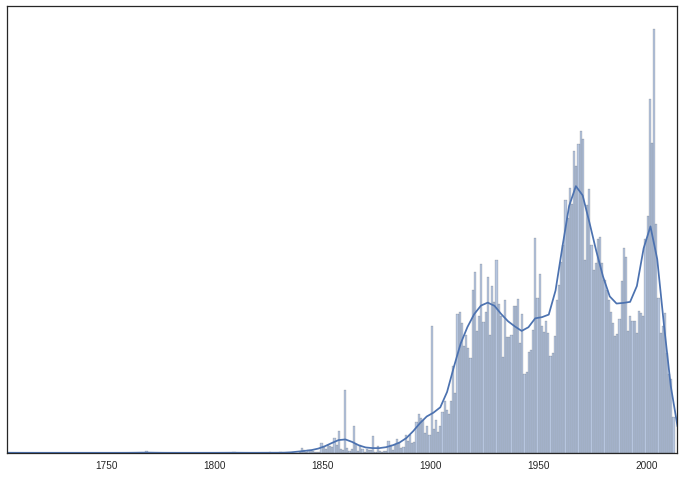

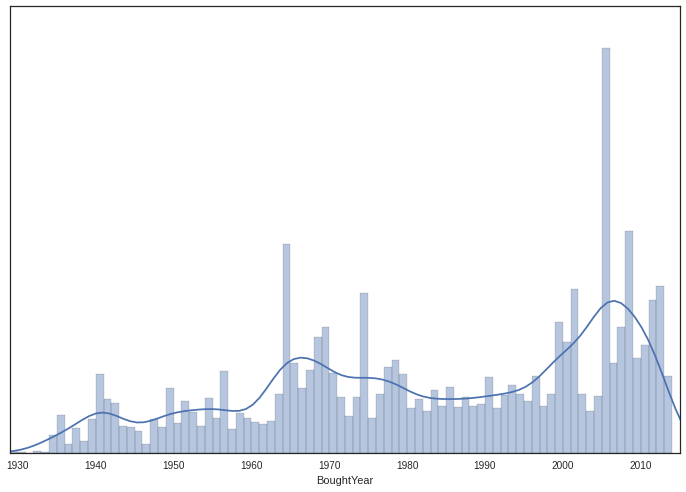

In [4]:
draw_histogram(dates)
draw_histogram(data.BoughtYear)

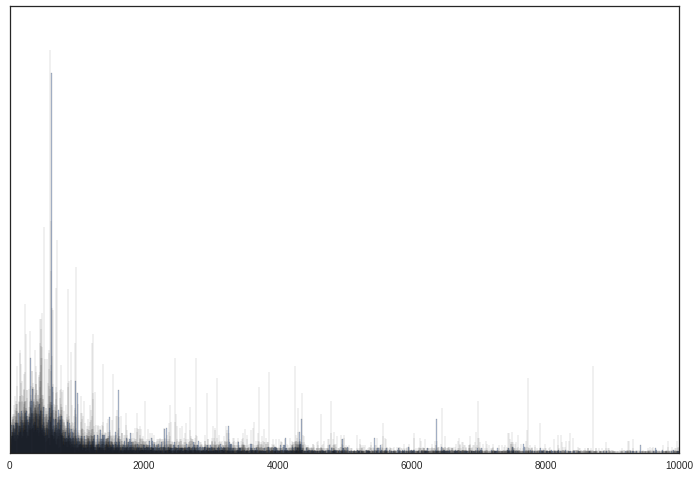

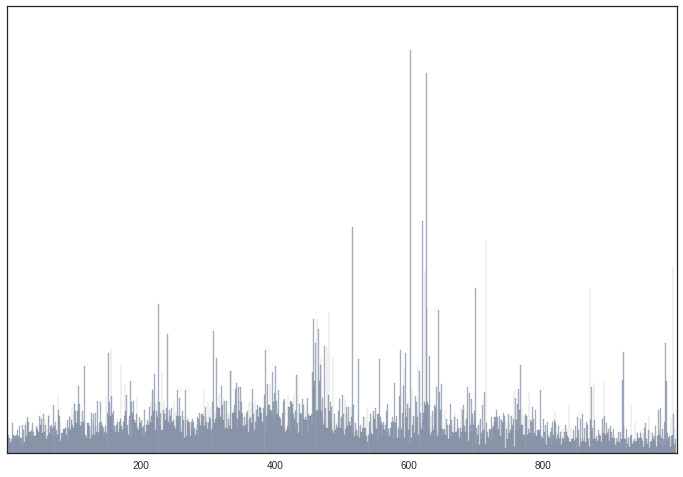

In [5]:
pos_areas = np.array([x for x in filter(lambda x: x > 0 and x < 10000, areas)])
draw_histogram(pos_areas, kde = False)

pos_areas = np.array([x for x in filter(lambda x: x > 0 and x < 1000, areas)])
draw_histogram(pos_areas, kde = False)

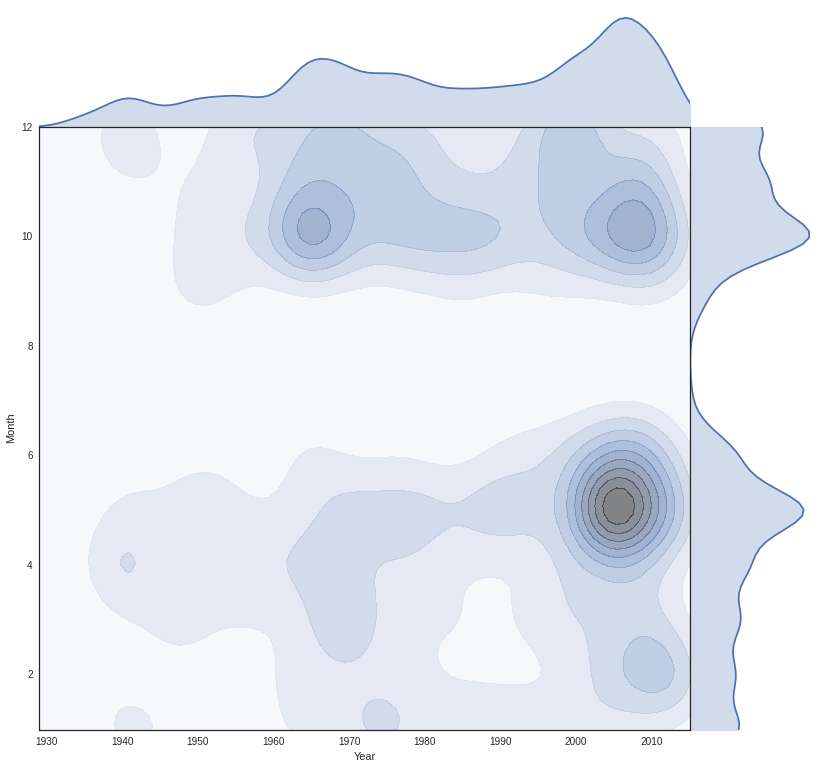

In [6]:
years = np.array([x.year for x in data['nominal'] if x.year > 0])
months = np.array([x.month for x in data['nominal'] if x.month > 0])

sns.set_style("white")
sns.despine()
joint = sns.jointplot(years, months, stat_func=None,
                                 kind='kde', space=0, alpha=0.5)
joint.fig.set_size_inches(12,11)
ax = joint.ax_joint
ax.set_xlim([min(years), max(years)])
ax.set_ylim([min(months), max(months)])
ax.set_ylabel('Month')
ax.set_xlabel('Year')
plt.show()

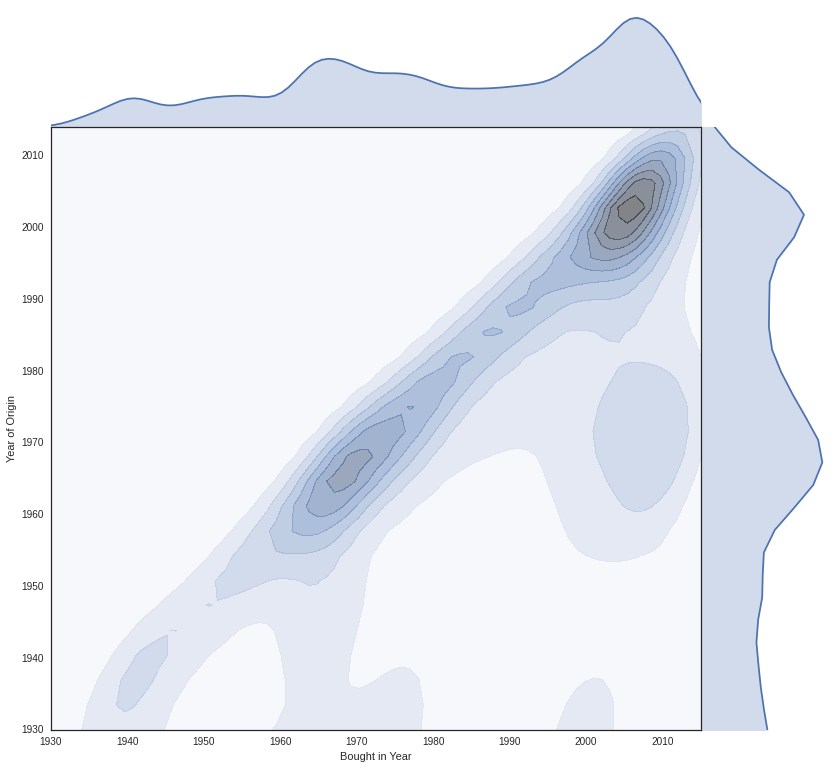

In [7]:
bought = np.array([x.year for x in data['nominal']])
orig = np.array(dates)

sns.set_style("white")
sns.despine()
joint = sns.jointplot(bought, dates, stat_func=None, dropna=True,
                                 kind='kde', space=0, alpha=0.5)
joint.fig.set_size_inches(12,11)
ax = joint.ax_joint
ax.set_xlim([1930, max(bought)])
ax.set_ylim([1930, max(orig)])
ax.set_ylabel('Year of Origin')
ax.set_xlabel('Bought in Year')
plt.show()

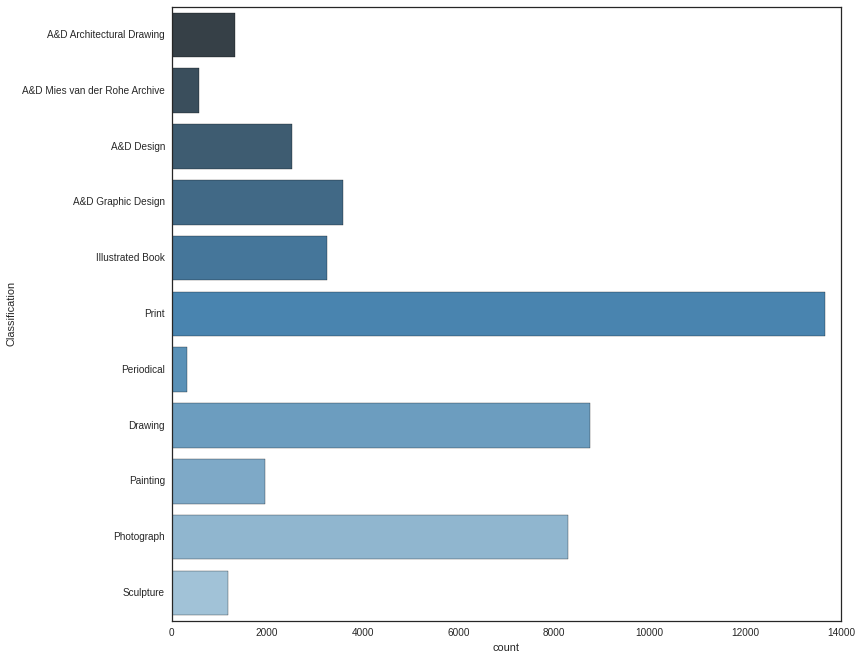

In [8]:
plt.figure(figsize=(12,11))
counts = [k for k, v in dict(data.Classification.value_counts()).items() if v > 300]
g = sns.countplot(y="Classification", data=data[data.Classification.isin(counts)], 
                  palette="Blues_d")
g.patch.set_visible(False)
plt.show()

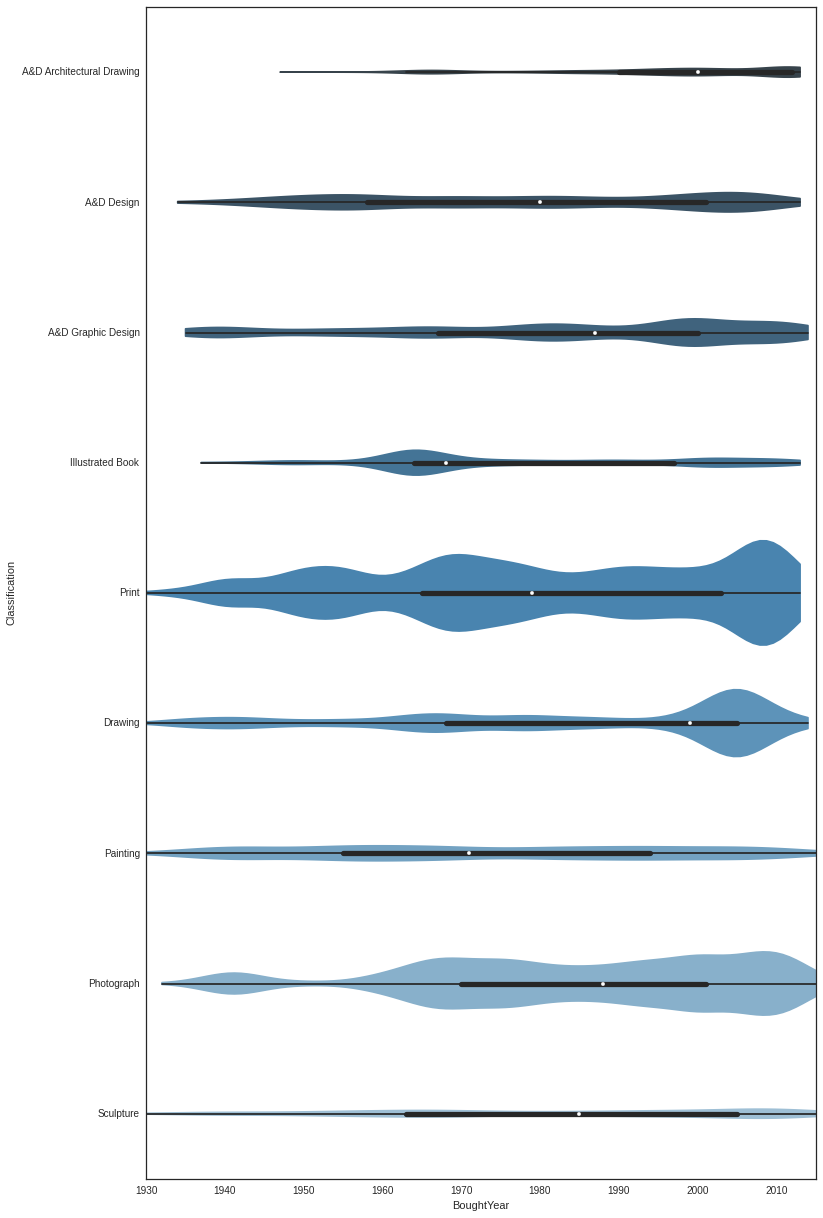

In [9]:
counts = [k for k, v in dict(data.Classification.value_counts()).items() if v > 1000]

plt.figure(figsize=(12,21))
g = sns.violinplot(x="BoughtYear", y="Classification", 
                   data=data[data.Classification.isin(counts)], 
                   scale='count', cut=0, bw='scott', palette="Blues_d");
g.set_xlim([1930, 2015])
plt.show()

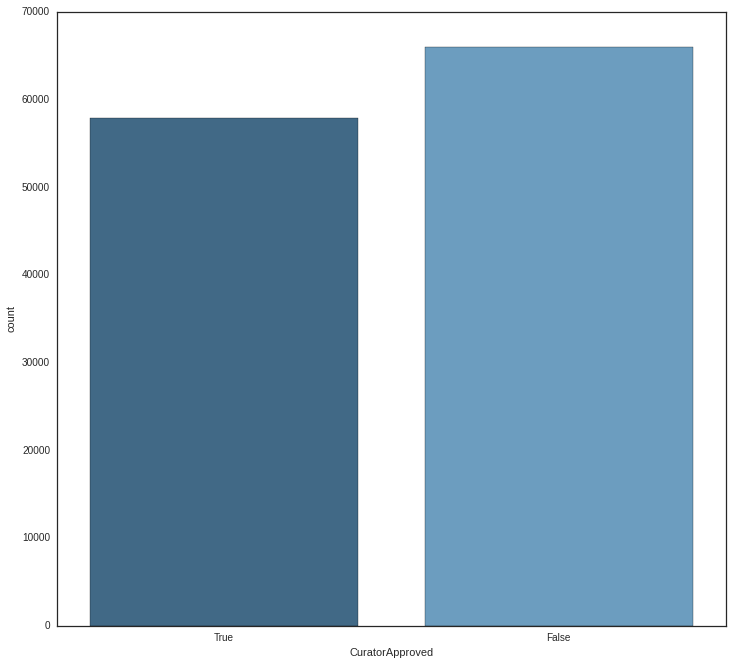

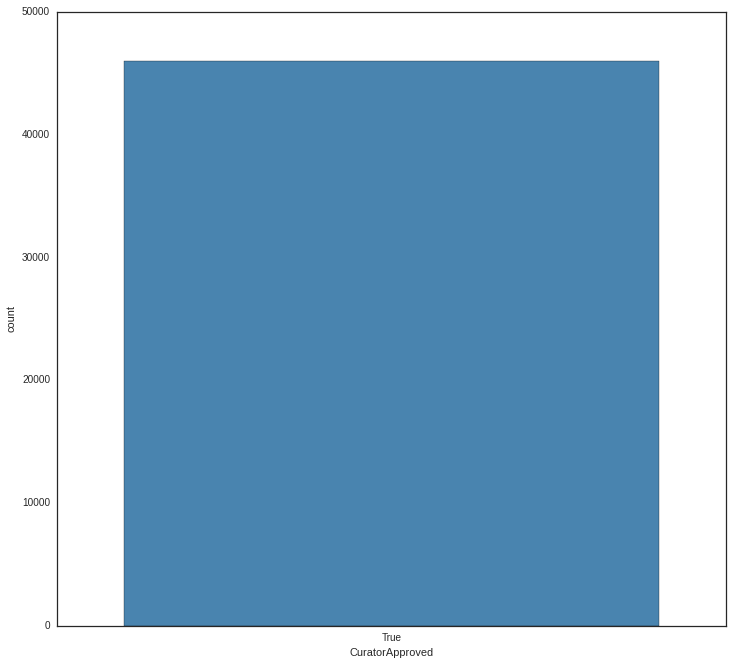

In [10]:
plt.figure(figsize=(12,11))
g = sns.countplot(x="CuratorApproved", data=raw_data, palette="Blues_d")
g.patch.set_visible(False)
plt.show()

plt.figure(figsize=(12,11))
g = sns.countplot(x="CuratorApproved", data=data, palette="Blues_d")
g.patch.set_visible(False)
plt.show()

Wow, so, after our little cleaning of the dataset, the only items that survive are curator approved. Although there still seem to be curated items slipping through our net, this is pretty good for a quick analysis.

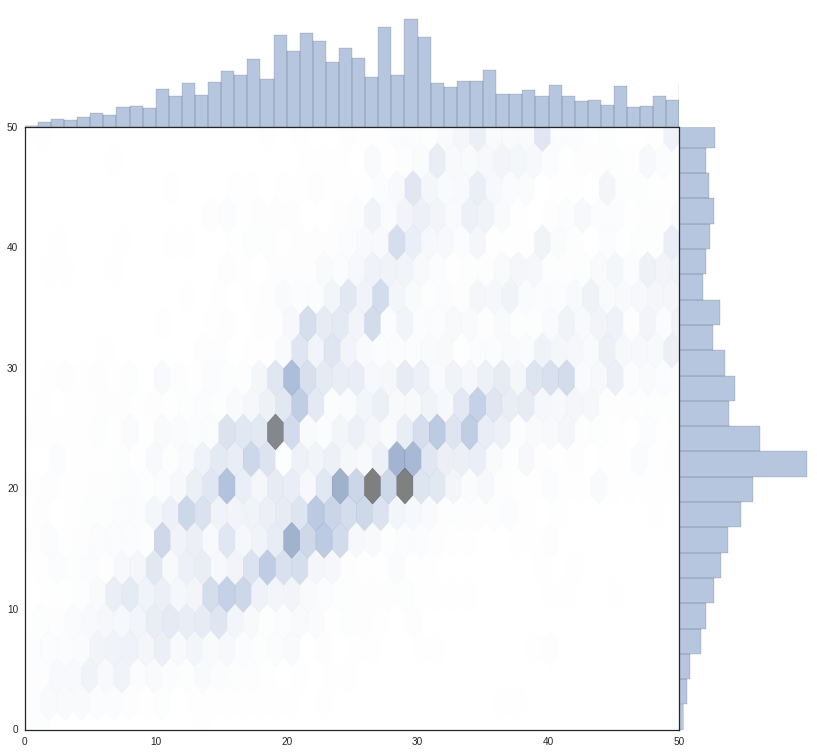

In [11]:
sns.set_style("white")
sns.despine()

width = np.array([int(math.floor(x)) for x in data.Width])
height = np.array([int(math.floor(x)) for x in data.Height])

num = min(max(width), max(height)) - max(min(width), min(height))

joint = sns.jointplot(width, height, stat_func=None,
                      xlim=[0,50], ylim=[0,50],
                      marginal_kws=dict(bins=num),
                      kind='hex', space=0, alpha=0.5)
joint.fig.set_size_inches(12,11)
plt.show()